# Applying Segmentation


## What is Segmentation?


In previous notebooks, we only addressed classification problems, which means predicting a class from an image (for example, "this is an image of the number 5" or "this is an image of a cat").
However, there are two other categories of image analysis: detection and segmentation.


### Object Detection in an Image


Object detection in an image involves drawing a bounding box around an object. For example, if you are trying to detect cats and an image contains both a dog and a cat, you train a model to draw a box around the cat.
Here is an image to visualize the concept of object detection:
![Detection](./images/detection.png)
Image from the [blogpost](https://machinethink.net/blog/object-detection-with-yolo/).


As you can imagine, this is a very interesting task in the field of image processing, but it is not what we will cover in this notebook.


### Object Segmentation in an Image


Segmentation aims to determine the class of each pixel in the image (for example, the pixel at position (120, 300) belongs to a dog). The goal is to obtain very precise information about the image content at the pixel level.
![Segmentation](./images/Segmentation.png)
Image from the [blogpost](https://towardsai.net/p/l/machine-learning-7).


There are several types of segmentation:
- **Semantic Segmentation**: This involves classifying each pixel in the image independently of the instance (for example, all cars will be colored red). This is the type of segmentation you see in the image above.
- **Instance Segmentation**: Here, each instance of the same class is segmented with a different color (for example, the first car in red, the second in orange, etc.).
- There are also other types of segmentation. For more information, you can refer to the [blogpost](https://medium.com/@arulkumarark1924/image-segmentation-techniques-for-computer-vision-bc5a68a4aa10).


In this notebook, we will work on an example of semantic segmentation.


## Dataset Used


We use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains a total of 7349 images, including 4978 images of dogs and 2371 images of cats. For each image, there are segmentation annotations as well as a bounding box around the animal's head.
![Oxford Pet](./images/oxford_pet.jpg)


We will only use the annotation corresponding to the animal's segmentation.


To retrieve and use the dataset, you need to download it directly from the website, as the version provided by torchvision does not include segmentation masks.


When the dataset you want to use is not directly available in torchvision, you need to create a class inheriting from the Dataset class to specify the data management for this dataset.


In [7]:
# Import nécessaire pour le projet
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import numpy as np

In [ ]:
class datasetSeg(Dataset):
  def __init__(self, path):
    self.path = path
    self.imagesPath,self.masksPath=self.loadDataset()
    
    self.resize=T.Resize((100, 100)) # Valeur de resize pour les images
    self.toTensor=T.ToTensor()
  
  def __len__(self):
    return len(self.imagesPath)
  
  def loadDataset(self): # Récuperation des liens vers les images et les annotations
    images=os.listdir(self.path+"images/")
    images=sorted(images)
    masks=os.listdir(self.path+"annotations/trimaps/")
    masks=sorted(masks)
    masks=[ mask for mask in masks if "._" not in mask ]
    images=[image for image in images if ".mat" not in image]
    return images, masks
  
  def __getitem__(self, index):
    image=Image.open(self.path+"images/"+self.imagesPath[index]).convert('RGB')
    # Resize des images et récuperation du masque de segmentation
    trimap=self.resize(Image.open(self.path+"annotations/trimaps/"+self.masksPath[index]).convert('L'))
    trimap=np.array(trimap)
    # Création des masques pour les classes
    class1 = (trimap == 1).astype(np.uint8)  
    class2 = (trimap == 2).astype(np.uint8)  
    class3 = (trimap == 3).astype(np.uint8)
    mask = np.stack([class1, class2, class3], axis=0)
    return self.toTensor(self.resize(image)), torch.tensor(mask)
        

Now that we have created our dataset class, we can load our dataset and examine its contents.


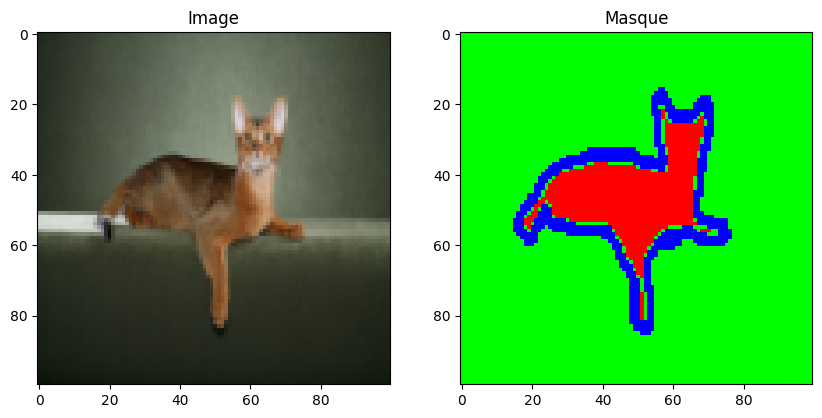

In [9]:
dataset=datasetSeg(path="./../data/OxfordPets/")
img=dataset[0][0].permute(1,2,0).numpy()
msk = dataset[0][1].permute(1, 2, 0).numpy() * 1.0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title('Image')
axs[1].imshow(msk)
axs[1].set_title('Masque')
plt.show()

We have the image and its segmentation. Now it is time to split our dataset and define our dataloaders:


In [10]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

## Model Architecture: U-Net


Unlike an image classification problem, the output of our neural network must have the same resolution dimensions as the input and one channel per class we want to segment (for example, if you want to segment ten classes on input images of size $224 \times 224 \times 3$, you will have an output of size $224 \times 224 \times 10$).
A classic convolutional network architecture, where the resolution gradually decreases to a fully connected classification layer, is therefore not suitable.
Instead, you can use the U-Net architecture.


Here is what the U-Net architecture looks like:
![U-Net](./images/unet.png)
Figure from this [blogpost](https://datasciencetoday.net/index.php/en-us/deep-learning/228-unet)


As you can see, the architecture is rather atypical. It consists of a contraction path (called an encoder) that reduces the image size like a classic CNN, and an expansion path (called a decoder) that increases the image size to a resolution identical to the input. The connections indicated by the black arrows allow preserving precise local information, while the encoder/decoder part allows detecting more abstract relationships between different pixels.
This architecture was first introduced for medical image segmentation in this [article](https://arxiv.org/abs/1505.04597). It is now used in many fields (segmentation, denoising, diffusion, etc.).


### Transposed Convolution


We have seen in detail the convolution layers, which allow performing operations on images with trainable parameters. We have seen that, thanks to the stride parameter, convolution layers can maintain the initial resolution or reduce it.
However, sometimes we need to increase the image resolution (for example, for the decoder part of the U-Net described above).


For this, several options can be considered:
- **Interpolation followed by convolution**: Similar to pooling but in the opposite direction, this idea involves using a non-trainable interpolation function to artificially enlarge the image.
- **Transposed Convolution**: This operation acts as the inverse of a convolution and allows increasing the image size. Here is an example of transposed convolution with a kernel of size $2 \times 2$. This is an operation that contains trainable parameters.
![ConvT](./images/convT.png)
Figure from [blogpost](https://d2l.ai/chapter_computer-vision/transposed-conv.html).


For those who want to dive into the details and understand the main differences between the two techniques, I recommend reading this [article](https://distill.pub/2016/deconv-checkerboard/).
In our implementation, we will use transposed convolution.


### PyTorch Implementation


It is time to implement the U-Net architecture in PyTorch:


In [11]:
# Fonction pour combiner couche de convolution, activation ReLU et BatchNorm pour éviter les copier coller 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
# Idem mais avec la convolution transposée
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )

class UNet(nn.Module):
  def __init__(self, num_classes=3):
    super().__init__()
    # encoder
    self.conv1=conv_relu_bn(3, 64, 3, 1, 1)
    self.conv2=conv_relu_bn(64, 64, 3, 1, 1)
    self.maxPool1=nn.MaxPool2d(2, 2)
    
    self.conv3=conv_relu_bn(64, 128, 3, 1, 1)
    self.conv4=conv_relu_bn(128, 128, 3, 1, 1)
    self.maxPool2=nn.MaxPool2d(2, 2)
    
    #Module central
    self.conv5=conv_relu_bn(128, 256, 3, 1, 1)
    self.conv6=conv_relu_bn(256, 256, 3, 1, 1)
    
    # Décodeur
    self.convT1=convT_relu_bn(256, 128, 4, 2, 1)
    self.conv7=conv_relu_bn(256, 128, 3, 1, 1)
    
    self.convT2=convT_relu_bn(128, 64, 4, 2, 1)
    self.conv8=conv_relu_bn(128, 64, 3, 1, 1)
    
    # On va prédire un channel par classe
    self.conv9=conv_relu_bn(64, num_classes, 3, 1, 1)     
    self.sigmoid=nn.Sigmoid()
  
  def forward(self,x):
    # Encodeur
    x=self.conv1(x)
    x1=self.conv2(x)
    
    x=self.maxPool1(x1)
    
    x=self.conv3(x)
    x2=self.conv4(x)
    x=self.maxPool2(x2)
    
    # Module central
    x=self.conv5(x)
    x=self.conv6(x)

    #Décodeur
    x=self.convT1(x)
    x=torch.cat((x,x2),dim=1)
    x=self.conv7(x)
    
    x=self.convT2(x)
    x=torch.cat((x,x1),dim=1)
    x=self.conv8(x)
    
    x=self.conv9(x)
    x=self.sigmoid(x)
    return x

## Model Training


To train the model, we will not distinguish between dogs and cats, but we will simply try to identify the pixels belonging to the animal, the edge pixels, and the background pixels.


In [12]:
# Nous défissons
model=UNet(num_classes=3).to('cuda')
criterion=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
epochs=5

The database is quite large and the model is quite deep. Training may take several dozen minutes if your GPU is not very powerful. (If you do not have a GPU, I do not recommend trying to train the model).


In [13]:
for epoch in range(epochs):
  train_loss=0
  for images,masks in train_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    optimizer.zero_grad()
    seg=model(images)
    loss=criterion(seg,masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f"step {epoch} train loss {train_loss/len(train_dataloader)}")  
  val_loss=0
  for images,masks in val_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    with torch.no_grad():
      seg=model(images)
      loss=criterion(seg,masks)
    val_loss += loss.item() 
  print(f"step {epoch} train loss {val_loss/len(val_dataloader)}")  

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


step 0 train loss 0.9442852522120063
step 0 train loss 0.9016501573806114
step 1 train loss 0.8738441905121744
step 1 train loss 0.8578698165873264
step 2 train loss 0.8354099944785789
step 2 train loss 0.8258832287281117
step 3 train loss 0.8052123431806211
step 3 train loss 0.7977393028583932
step 4 train loss 0.7819347337440208
step 4 train loss 0.7781971261856404


We can now calculate the accuracy on our test data.


In [14]:
def calculate_class_accuracy(preds, masks, class_idx):
  #On convertit les prédictions en valeur entre 0 et 1 pour chaque classe
  preds = torch.argmax(preds, dim=1)
  
  # On ne récupère que les pixels de la classe d'intêret
  preds_class = (preds == class_idx).float()
  masks_class = (masks == class_idx).float()
  
  # Calculer la précision pour la classe choisie
  correct = (preds_class == masks_class).float()
  accuracy = correct.sum() / correct.numel()
  return accuracy

model.eval()
test_accuracy = 0.0
num_batches = 0


with torch.no_grad(): # Désactivation du calcul du gradient
  for images, masks in test_dataloader:
    images = images.to('cuda')
    masks = masks.to('cuda').long()
    
    seg = model(images)
    
    # On calcule la précision pour la classe d'intêret (0 correspond à la segmentation de l'animal)
    class_idx = 0
    batch_accuracy = calculate_class_accuracy(seg, masks, class_idx)
    
    test_accuracy += batch_accuracy.item()
    num_batches += 1

# On calcule la précision moyenne sur l'ensemble du dataset de test
test_accuracy /= num_batches
print(f'Précision pour la segmentation de l animal : {test_accuracy*100:.1f}%')

Précision pour la segmentation de l animal : 43.4%


### Visualization


We can visualize the results of our training on an image from the test dataset. For a segmentation task, it is interesting to see what the result gives on one or more examples. If you run the following code block several times, you will see the generation on different images.


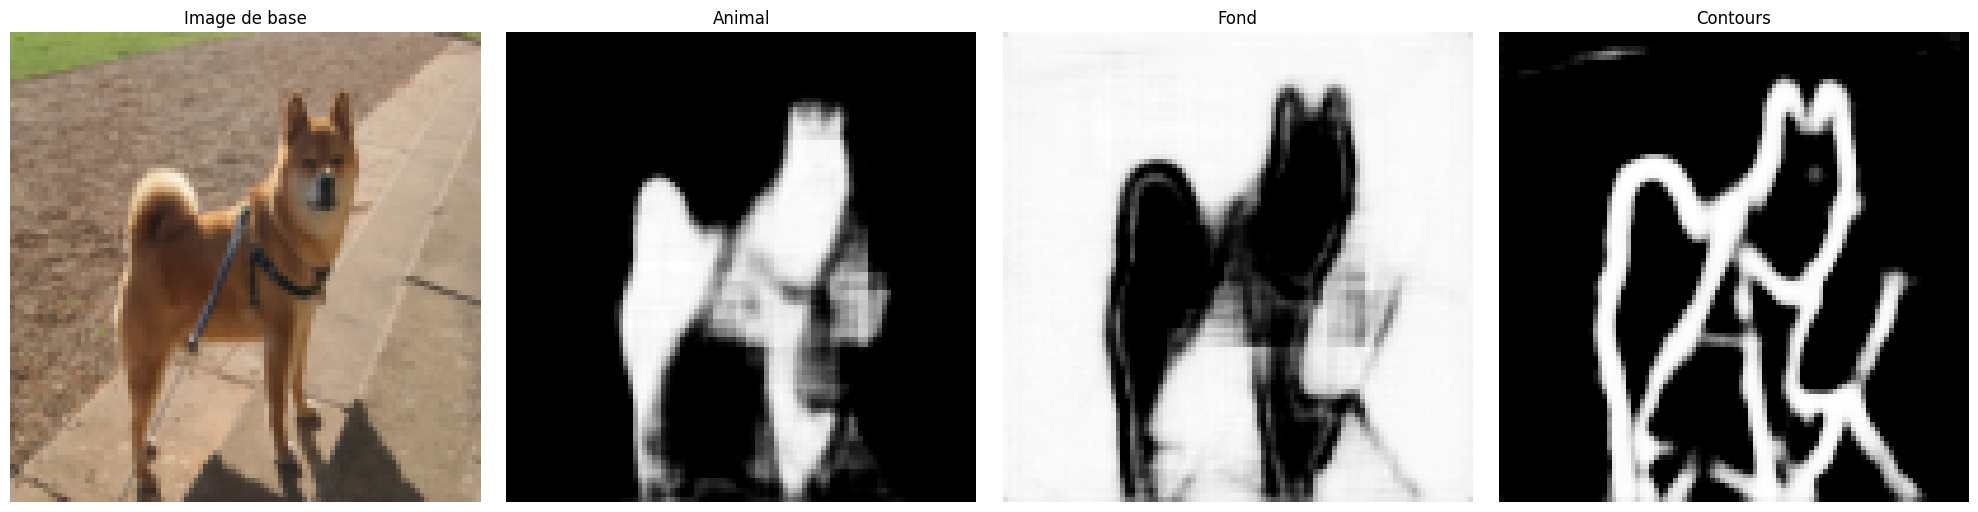

In [32]:
images,labels=next(iter(test_dataloader))

#Isolons un élément 
image=images[0].unsqueeze(0).to('cuda') # Le unsqueeze permet de garder la dimension batch
with torch.no_grad():
  seg=model(image)
    
# Affichons la segmentation prédite par le modèle pour cet élément
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Image de base')
axs[0].axis('off')

axs[1].imshow(seg[0][0].cpu().numpy(), cmap='gray')
axs[1].set_title('Animal')
axs[1].axis('off')

axs[2].imshow(seg[0][1].cpu().numpy(), cmap='gray')
axs[2].set_title('Fond')
axs[2].axis('off')

axs[3].imshow(seg[0][2].cpu().numpy(), cmap='gray')
axs[3].set_title('Contours')
axs[3].axis('off')

plt.tight_layout()
plt.show()

Despite the relatively low accuracy score of 43%, we notice that the segmentation is correct on most images.


### Exercise to Do


To practice, you can try to improve the model's performance. You can increase the number of layers, change the number of filters in the layers, add dropout, use batch normalization, increase the number of training epochs, change the learning rate, etc.
Try to maximize the performance of your segmentation model!
